In [ ]:
from PIL import Image
from tqdm import tqdm
from os import path
import sys
sys.path.append('../scripts')
from utils.image_processing import SidewalkBalletImage, draw_with_boxes
from utils.prompts import prompt7, prompt7_question
from utils.tools import compute_median_depth
from utils.partition import greedy_partition, merge_bboxes

from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from itertools import combinations
from qwen_vl_utils import process_vision_info
import torch

#### Please download the model before running the code!!!
# model_name = <path to your model>, See Repo Instruction for the downloading of MINGLE-1.0

### 1 Check the image

First of all, here we have a street-level image, which is from Mapillary (id: 2960436387521052), you can try the other one by yourself. 


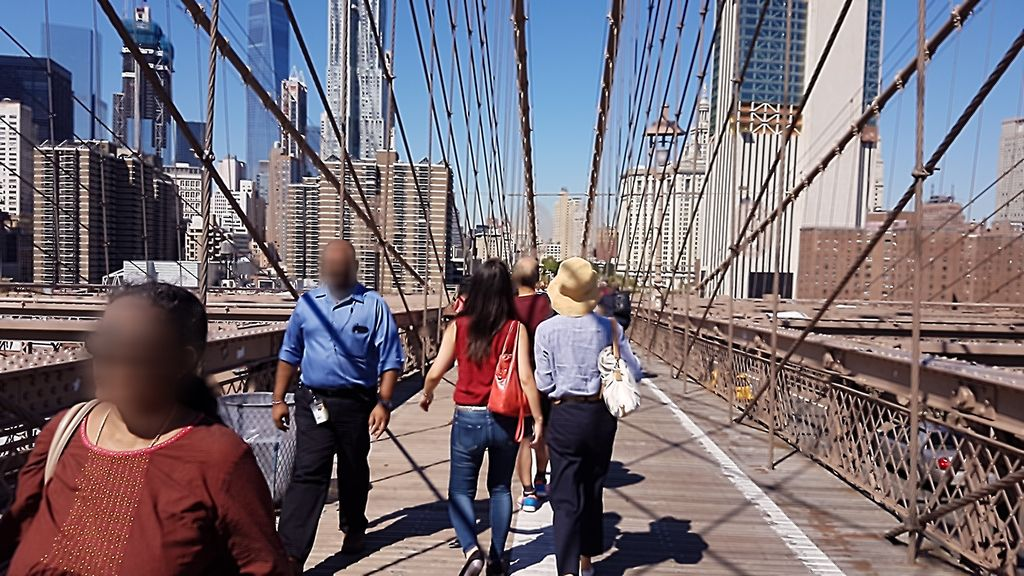

In [4]:
image = Image.open("../example/2960436387521052.jpg")
image

### 2 Get the Bounding Boxes of persons in that Image

Here we choose to use ATSS-Swin-L-DyHead, but of course you may choose whatever you like to detect, such as YOLO series.
And from that point, here we get five bounding boxes of pedestrians.

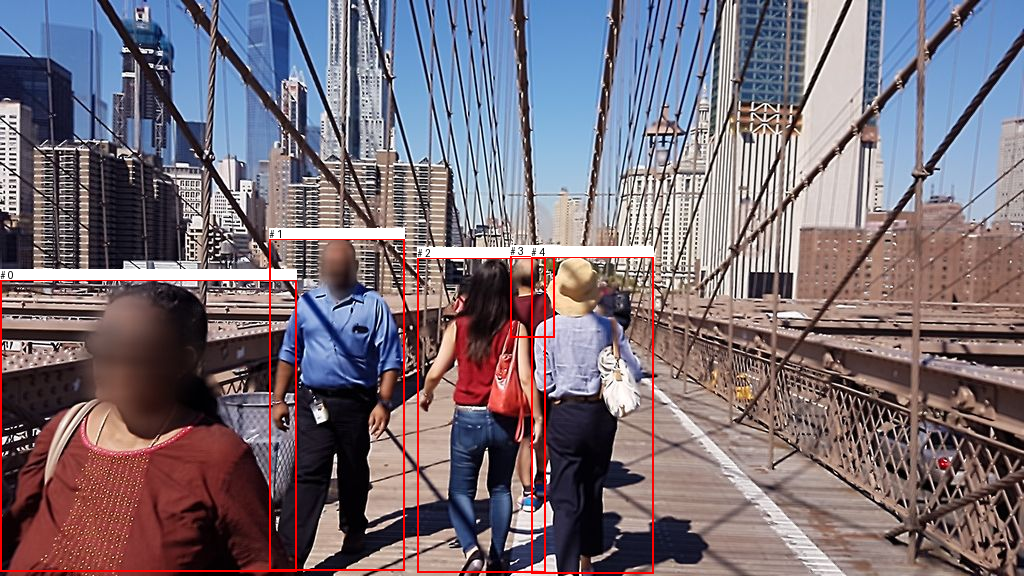

In [5]:
# for the image of example/2818900025043164.jpg
# box_detected_person = [[48, 290, 137, 518], [136, 264, 166, 340], [153, 286, 200, 396], [231, 263, 268, 348], [263, 269, 286, 321], [318, 159, 496, 760], [518, 114, 700, 724]]

box_detected_person = [[0, 279, 296, 571], [269, 238, 404, 570], [417, 257, 545, 572], [510, 255, 554, 337], [531, 256, 653, 573]]
img = SidewalkBalletImage(image, box_detected_person)
img.show(all_boxes = True)

#

### 3 Get the depth Map

Before firing, we still need to achieve the depth map of the image. In our paper, we adopted this model: https://github.com/Lavreniuk/EVP You may just use its example code to generate the depth map.
As you may see the depth map is in a low resolution. Yet it is fine, meaning that there is still a lot of room for us to improve.



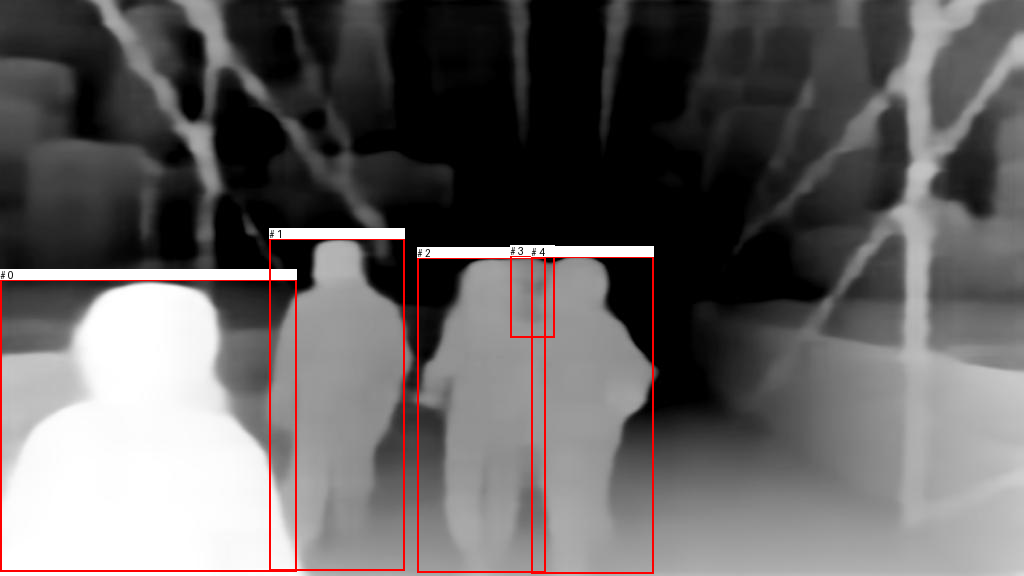

In [6]:
# So let's take a look at the depth map
image_depth = Image.open("../example/2960436387521052_depth.jpg")
img_depth = SidewalkBalletImage(image_depth, box_detected_person)
img_depth.show(all_boxes = True)

### 4 Pairwise Group Detection

OK, now we have the bounding boxes of persons in the image. As you can see not every person is detected. (two more in the bus stop)

In [ ]:
min_pixels = 256 * 28 * 28
max_pixels = 1280 * 28 * 28
processor = AutoProcessor.from_pretrained(model_name, min_pixels=min_pixels, max_pixels=max_pixels)

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="cuda",
)

In [8]:
items = list(range(len(box_detected_person)))
pairs = list(combinations(items, 2))
result = {}

for pair in tqdm(pairs):
    # perpare the message for the model
    box1, box2 = box_detected_person[pair[0]], box_detected_person[pair[1]]
    img_focused = img.focus(box_ids=pair)
    img_focused_depth = img_depth.focus(box_ids=pair)
    depth1, depth2 = compute_median_depth(image_depth, [box1, box2])

    messages = prompt7_question(
        img_focused.show(all_boxes=True, width=1, labels=False),
        img_focused_depth.show(all_boxes=True, width=1, labels=False),
        prompt7(img_focused.boxes, depth1, depth2),
    )
    
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    result[pair] = output_text[0].strip().strip(".")

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


In [9]:
result

{(0, 1): 'No',
 (0, 2): 'No',
 (0, 3): 'No',
 (0, 4): 'No',
 (1, 2): 'No',
 (1, 3): 'No',
 (1, 4): 'No',
 (2, 3): 'No',
 (2, 4): 'Yes',
 (3, 4): 'No'}

### 5 Group the results!

Bingo, only the pair of 2 and 4 are judged as a group, so let's merge them together!

In [25]:
p, sc = greedy_partition(items, result)
merged_bboxes = merge_bboxes(p, box_detected_person)
boxes_pred = [box for box, cnt in merged_bboxes if cnt > 1]
image_pred = draw_with_boxes(img.show(all_boxes = True), boxes_pred, width = 5, color = "blue", labels=False, text_height = 10)     

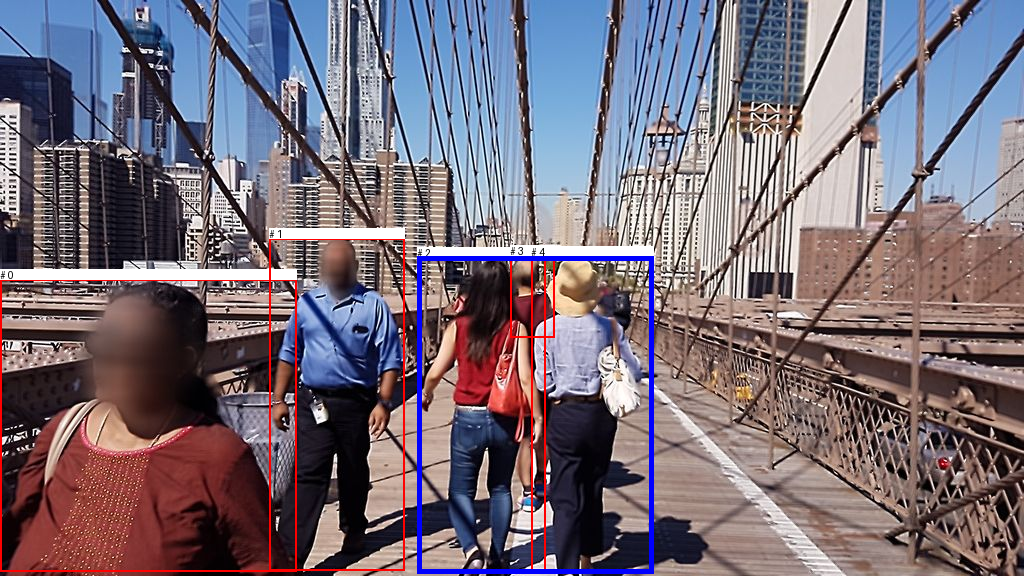

In [24]:
image_pred